# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [23]:
# import libraries
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc as Fauc
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, FloatType, StringType
from pyspark.sql.functions import col, udf, asc, desc, min, max, count, avg, stddev_pop, countDistinct, last, first, when
from pyspark.sql.functions import isnan, lit, greatest, round
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import Window
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoderEstimator, StandardScaler, SQLTransformer
from pyspark.ml.pipeline import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .master("local") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [25]:
# load data subset
data_path = 'mini_sparkify_event_data.json'
data = spark.read.json(data_path)
data.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
# check contents
data.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

---
### Data Cleaning
**Null distribution check**

In [6]:
# data size
data.count()

286500

In [7]:
# print number of Null's for each column
for column in data.columns:
    print(column, data.where(col(column).isNull()).count())

artist 58392
auth 0
firstName 8346
gender 8346
itemInSession 0
lastName 8346
length 58392
level 0
location 8346
method 0
page 0
registration 8346
sessionId 0
song 58392
status 0
ts 0
userAgent 8346
userId 0


>'artist', 'length', 'song' columns have the same number of Null's, i.e. 58392<br>
These can be explained as (data size) - (number of 'NextSong' page) = 286500 - 228108 = 58392<br>
(Number of 'NextSong' page is obtained as next cell.)<br>
It is reasonable that song information is available only on playing pag, and so these Null's are not erroneous.

>'firstName', 'gender', 'lastName', 'location', 'registration', 'userAgend' have the same number of Null's, i.e. 8346<br>
These can be explained as (number of 'auth' as 'Logged Out') + (number of 'auth' as 'Guest') = 8249 + 97 = 8346<br>
(Number of 'auth' breakdown is obtained as 2 following cell.)<br>
It is reasonable that user information is not available on 'Logged Out' state and 'Guest' state, and so these Null's are not erroneous.

>And as we found that user information is not available when 'auth' is 'Logged Out' or 'Guest', we will drop rows with these 'auth' values for our churn analysis.

In [8]:
# check distribution of page type
data.groupBy('page').count().sort(desc('count')).collect()

[Row(page='NextSong', count=228108),
 Row(page='Home', count=14457),
 Row(page='Thumbs Up', count=12551),
 Row(page='Add to Playlist', count=6526),
 Row(page='Add Friend', count=4277),
 Row(page='Roll Advert', count=3933),
 Row(page='Login', count=3241),
 Row(page='Logout', count=3226),
 Row(page='Thumbs Down', count=2546),
 Row(page='Downgrade', count=2055),
 Row(page='Help', count=1726),
 Row(page='Settings', count=1514),
 Row(page='About', count=924),
 Row(page='Upgrade', count=499),
 Row(page='Save Settings', count=310),
 Row(page='Error', count=258),
 Row(page='Submit Upgrade', count=159),
 Row(page='Submit Downgrade', count=63),
 Row(page='Cancel', count=52),
 Row(page='Cancellation Confirmation', count=52),
 Row(page='Register', count=18),
 Row(page='Submit Registration', count=5)]

In [9]:
# check distribution of auth state
data.groupBy('auth').count().sort(desc('count')).collect()

[Row(auth='Logged In', count=278102),
 Row(auth='Logged Out', count=8249),
 Row(auth='Guest', count=97),
 Row(auth='Cancelled', count=52)]

In [10]:
# drop 'Logged-Out' state and 'Guest' state
df = data.filter("auth != 'Logged Out' and auth != 'Guest'")

---
**'userId' check**

In [11]:
# check user id statistics
data.describe('userId').show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



>The minimum value is empty string. Let's check the empty userId's rows as follows.

In [12]:
data.filter('userId==""').show(10)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

>It seems like these are garbage data, and they must be dropped.

In [13]:
# drop empty user id row
df = df.filter('userId!=""')

---
**'sessionId' check**

In [14]:
# check session id statistics
data.describe('sessionId').show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



>'sessionId' seems OK.

---
**Data cleaning summary:**<br>
Above data cleaning steps are combined into following script.<br>
>PS: There is a feedback from feature engineering step and we also have to exclude rows of users who have only 1 song play count or less. The procedure is added into the end of script.

In [4]:
# Data Cleaner (subroutine)
def add_data_cleaner():
    '''
    OUTPUT:
    stages - (list) list of transformer to be used as 'stages' argument of pyspark Pipeline() constructor

    DESCRIPTION:
    This is a subroutine of create_preprocess_pipeline() function.
    Stages added by this function will clean raw pyspark dataframe for next steps.
    '''
    stages = []  # pipeline stage list

    # filter rows with userId==Null or sessionId==Null, just in case
    sqlTrans = SQLTransformer(
        statement="SELECT * FROM __THIS__ WHERE userId IS NOT NULL AND sessionId IS NOT NULL")
    stages.append(sqlTrans)

    # drop empty user id row
    sqlTrans = SQLTransformer(
        statement="SELECT * FROM __THIS__ WHERE userId != ''")
    stages.append(sqlTrans)

    # drop 'Logged-Out' state and 'Guest' state
    sqlTrans = SQLTransformer(
        statement="SELECT * FROM __THIS__ WHERE auth != 'Logged Out' AND auth != 'Guest'")
    stages.append(sqlTrans)

    # exclude rows with user who has only one song play or less
    sqlTrans = SQLTransformer(statement=" \
        SELECT * \
        FROM __THIS__ \
        WHERE userId NOT IN ( \
            SELECT DISTINCT userId \
            FROM \
            (SELECT userId, page, \
                COUNT(CASE WHEN page = 'NextSong' THEN page END) \
                OVER(PARTITION BY userId) AS songCount \
            FROM __THIS__) AS user_page_count \
            WHERE user_page_count.songCount < 2)")
    stages.append(sqlTrans)

    return stages

The script is in form of transformer in order to combine with label definition and feature engineering steps and put into one pipeline.<br>
For data cleaning only, it can be used as follows.

In [5]:
# clean 'data' and output into 'df' dataframe
stages = add_data_cleaner()
pipeline = Pipeline(stages=stages)
model = pipeline.fit(data)
df = model.transform(data)

---
# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

---
### Label Definition
First, let's prepare 'Churn' column as label.

In [345]:
# define churn event as 'Cancellation Confirmation' and add a column to store the churn event
flag_churn_event = udf(lambda page: 1 if page == 'Cancellation Confirmation' else 0,
                       IntegerType())

df = df.withColumn('churn_event', flag_churn_event('page'))

# add a column to store cumulative sum of the churn flag as label
user_window = Window \
    .partitionBy('userId') \

df = df.withColumn('Churn', max('churn_event').over(user_window))

In [283]:
# check number of users in each group
df.groupBy('Churn').agg(countDistinct('userId')).show()

+-----+----------------------+
|Churn|count(DISTINCT userId)|
+-----+----------------------+
|    1|                    52|
|    0|                   173|
+-----+----------------------+



In [284]:
# churn rate
df.groupBy('userId').agg(max('Churn').alias('Churn')).agg(avg('Churn')).show()

+------------------+
|        avg(Churn)|
+------------------+
|0.2311111111111111|
+------------------+



>Churn users are about 23% in all users.

Now label column is added and we have to check whether there is any other informations directly correlating to it.<br>
Spacifically, we check 'page' column to find 'churn' specific events.

In [346]:
# collect unique events for churn and no-churn users
churn_pages = df.filter('Churn == 1').select('page').distinct().collect()
no_churn_pages = df.filter('Churn == 0').select('page').distinct().collect()

In [347]:
# check delta of the two sets
print('Churn - NO-Churn', set(churn_pages) - set(no_churn_pages))
print('No-Churn - Churn', set(no_churn_pages) - set(churn_pages))

Churn - NO-Churn {Row(page='Cancellation Confirmation'), Row(page='Cancel')}
No-Churn - Churn set()


>Churn specific events are 'Cancellation Confirmation' and 'Cancel'.<br>
They don't be dropped now, but they will be excluded in feature engineering step.

Just in case, we also check the very last event of churn users.

In [348]:
# find the last event of churn user
user_desc_prec_window = Window \
    .partitionBy('userId') \
    .orderBy(desc('ts')) \
    .rowsBetween(Window.unboundedPreceding, Window.currentRow)

df.filter('Churn==1').sort(desc('ts')).groupBy('userId').agg(
    first('page').alias('last_event')).groupBy('last_event').count().show()

+--------------------+-----+
|          last_event|count|
+--------------------+-----+
|              Cancel|    1|
|Cancellation Conf...|   51|
+--------------------+-----+



>Either of the two can be the last event for churn users.

---
**Label definition summary:**<br>
Above label definition steps are combined into following script.<br>

In [5]:
# Label Maker (subroutine)
def add_label_maker(stages):
    '''
    INPUT:
    stages - (list) list of transformer to be used as 'stages' argument of pyspark Pipeline() constructor
                It should be an output of 'create_data_cleaner()' function.

    OUTPUT:
    stages - (list) list of transformer to be used as 'stages' argument of pyspark Pipeline() constructor

    DESCRIPTION:
    This is a subroutine of create_preprocess_pipeline() function.
    Stages added by this function will make label column in target pyspark dataframe.
    It also drops rows which the label column directly depends on.
    '''
    # 'churn_event'
    # add a column to store churn event as integer
    sqlTrans = SQLTransformer(statement=" \
        SELECT *, \
            CASE WHEN page = 'Cancellation Confirmation' THEN 1 ELSE 0 END AS churn_event \
        FROM __THIS__")
    stages.append(sqlTrans)

    # 'Churn'
    # add a column to store cumulative sum of churn flag
    sqlTrans = SQLTransformer(statement=" \
        SELECT *, \
            MAX(churn_event) OVER ( \
                PARTITION BY userId \
            ) AS Churn \
        FROM __THIS__")
    stages.append(sqlTrans)

    return stages

The script is in form of transformer so that it can be combined with data cleaning and feature engineering steps and put into one pipeline.<br>
For data cleaning and label definition, it can be used as follows.

In [7]:
# clean 'data' and define label, then output into 'df' dataframe
stages = add_data_cleaner()
stages = add_label_maker(stages)  # this needs to follow data cleaning step
pipeline = Pipeline(stages=stages)
model = pipeline.fit(data)
df = model.transform(data)

---
### Feature Exploration
We will explore features that can be obtained from data, comparing churn and no-churn user groups.<br>
We could explore all possible features, but this time, we will focus on time series data.

**Event distribution**<br>
First, we visualize event distribution in timeline to see if there is some difference in patterns between churn and no-churn.<br>
Seaborn heatmap will be used for visualization.

In [22]:
# index page colum
indexer = StringIndexer(inputCol='page', outputCol='event')
indexerModel = indexer.fit(df)
df_event = indexerModel.transform(df)

In [68]:
# change to pandas dataframe for visualization
pd_event = df_event.toPandas()

In [69]:
# change ts into second unit
pd_event['ts'] = pd_event['ts'].apply(lambda x: int(x / 1000))

In [146]:
# create user id list for both groups
churn_users = pd_event.query('Churn==1')['userId'].unique()
no_churn_users = pd_event.query('Churn==0')['userId'].unique()
len(churn_users), len(no_churn_users)

(52, 173)

In [147]:
# sample from each user list and extract ts-userId event table

# we can shuffle if we want by enable following two lines
# np.random.shuffle(churn_users)
# np.random.shuffle(no_churn_users)

pd_churn_users = pd_event[pd_event['userId'].isin(churn_users[:15])] \
    .groupby(['ts'])['userId', 'event'].min()
pd_no_churn_users = pd_event[pd_event['userId'].isin(no_churn_users[:15])] \
    .groupby(['ts'])['userId', 'event'].min()

# pivot table and transpose to make ts-userId event table
pd_churn_users = pd_churn_users \
    .pivot(columns='userId', values='event').transpose()
pd_no_churn_users = pd_no_churn_users \
    .pivot(columns='userId', values='event').transpose()

# check shape of tables
print(pd_churn_users.shape)
print(pd_no_churn_users.shape)

(15, 17473)
(15, 25374)


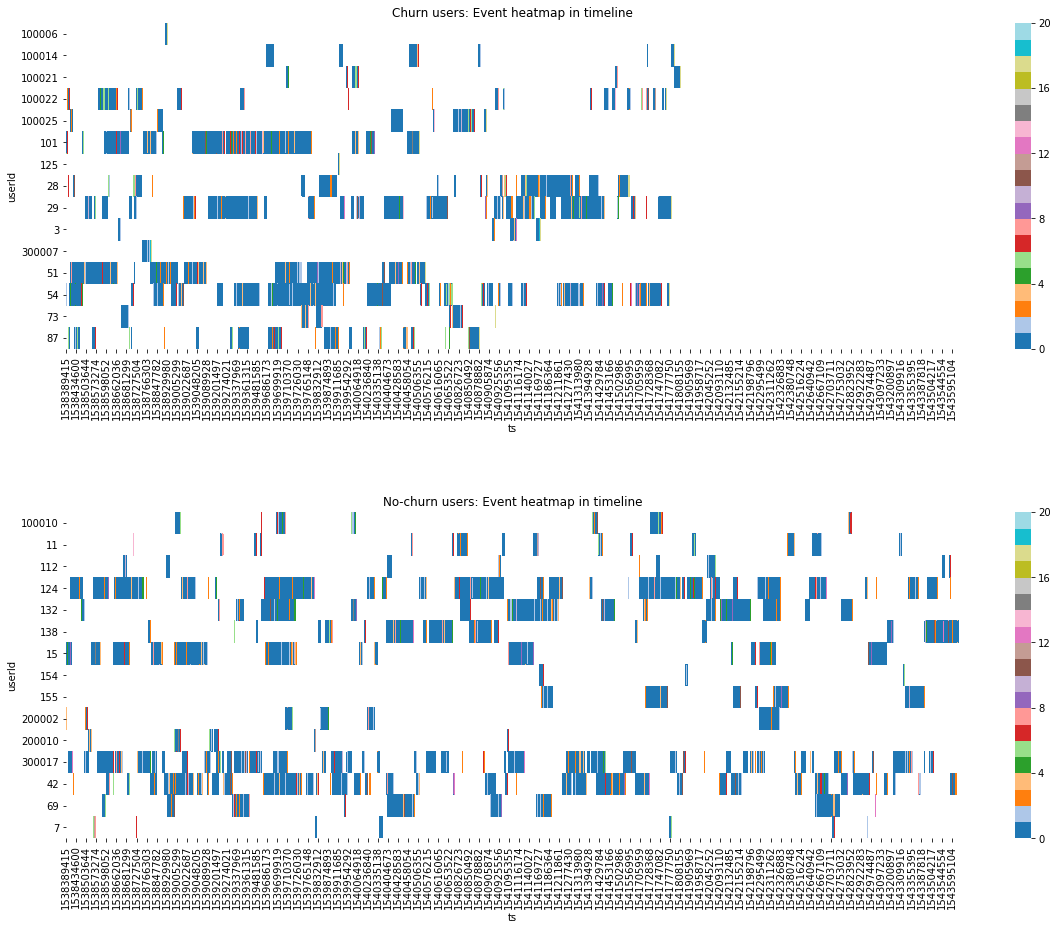

In [148]:
# heat map (full ts range)
fig, ax = plt.subplots(2, 1, figsize=(20, 15), sharex=True)
facet0 = sns.heatmap(ax=ax[0], data=pd_churn_users,
                     cmap='tab20', vmin=0, vmax=20)
# facet0.set_facecolor('silver')
ax[0].set_title('Churn users: Event heatmap in timeline')
facet1 = sns.heatmap(ax=ax[1], data=pd_no_churn_users,
                     cmap='tab20', vmin=0, vmax=20)
# facet1.set_facecolor('silver')
ax[1].set_title('No-churn users: Event heatmap in timeline')
plt.subplots_adjust(hspace=0.5)
plt.show()

>It is for granted, but churn users activities are relatively shorter in dataset. But using the service period directly does not make sense if we want to make a churn prediction model. 

Next, let's zoom in to the last 1000 events experience.

In [144]:
# the number in chart and event name mapping can be obtained as follows
i_and_label = [(i, label) for (i, label) in enumerate(indexerModel.labels)]
print(i_and_label)

[(0, 'NextSong'), (1, 'Thumbs Up'), (2, 'Home'), (3, 'Add to Playlist'), (4, 'Add Friend'), (5, 'Roll Advert'), (6, 'Logout'), (7, 'Thumbs Down'), (8, 'Downgrade'), (9, 'Settings'), (10, 'Help'), (11, 'Upgrade'), (12, 'About'), (13, 'Save Settings'), (14, 'Error'), (15, 'Submit Upgrade'), (16, 'Submit Downgrade'), (17, 'Cancellation Confirmation'), (18, 'Cancel')]


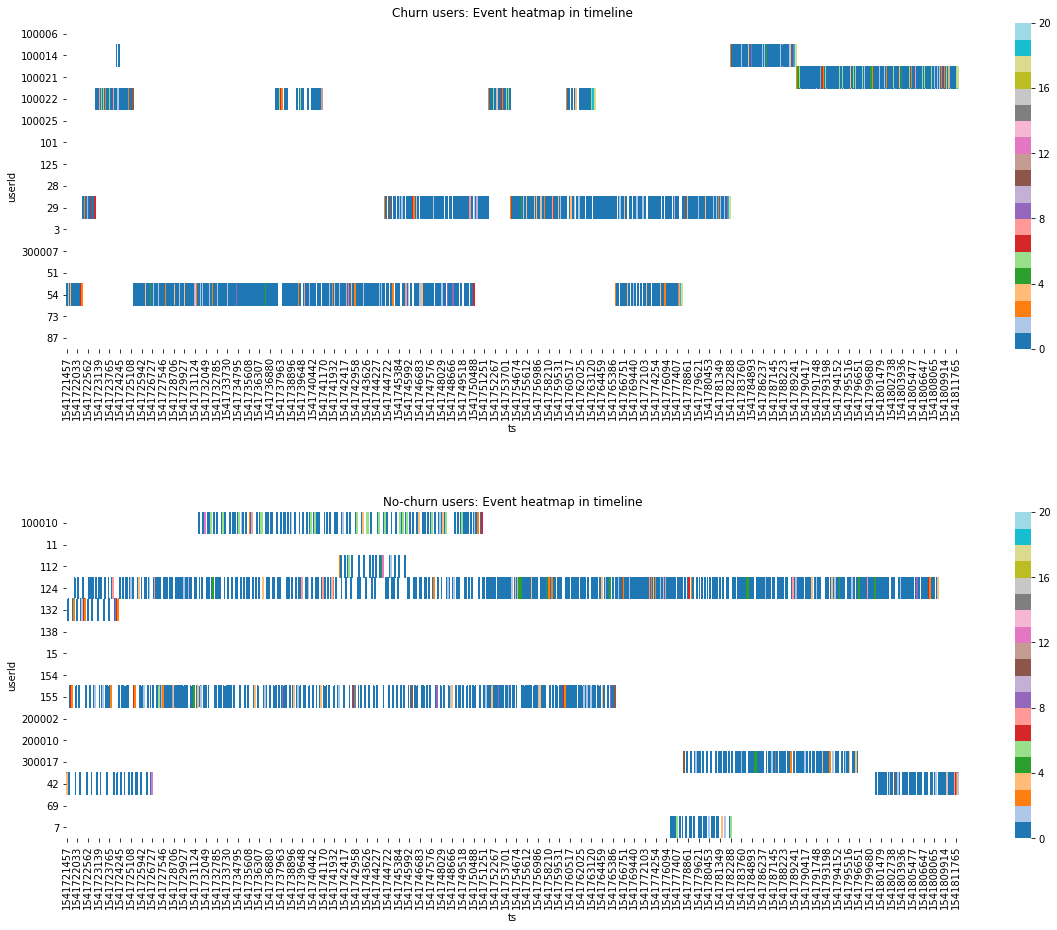

In [149]:
# heat map (last 1000 ts of churn)
ts_start = pd_churn_users.shape[1] - 1000
ts_end = pd_churn_users.shape[1]
fig, ax = plt.subplots(2, 1, figsize=(20, 15), sharex=True)
facet0 = sns.heatmap(ax=ax[0], data=pd_churn_users.iloc[:, ts_start:ts_end],
                     cmap='tab20', vmin=0, vmax=20)
# facet0.set_facecolor('black')
ax[0].set_title('Churn users: Event heatmap in timeline')
facet1 = sns.heatmap(ax=ax[1], data=pd_no_churn_users.iloc[:, ts_start:ts_end],
                     cmap='tab20', vmin=0, vmax=20)
# facet1.set_facecolor('black')
ax[1].set_title('No-churn users: Event heatmap in timeline')
plt.subplots_adjust(hspace=0.5)
plt.show()

>In this scale, we can see difference of patterns. No-churn users have more short blanks between events.<br>
In order to quantify these blank patterns, we could calculate intervals between events.

We continue to check if average event intervals are different between churn and no-churn users.<br>
We will also check if we can use level information (paid or free).

In [294]:
# clean 'data' and define label, then output into 'df' dataframe
stages = add_data_cleaner()
stages = add_label_maker(stages)  # this needs to follow data cleaning step
pipeline = Pipeline(stages=stages)
model = pipeline.fit(data)
df = model.transform(data)

In [295]:
# add a column to store event interval till next event
user_page_desc_one_prec = Window \
    .partitionBy('userId', 'page') \
    .orderBy(desc('ts')) \
    .rowsBetween(-1, Window.currentRow)

df = df.withColumn('interval', first('ts').over(
    user_page_desc_one_prec)/1000 - last('ts').over(user_page_desc_one_prec)/1000)

# check the head of events
df.select('userId', 'ts', 'page', 'interval').sort('userId', 'ts').show(10)

+------+-------------+---------+--------+
|userId|           ts|     page|interval|
+------+-------------+---------+--------+
|    10|1538965220000| NextSong|   265.0|
|    10|1538965485000| NextSong|   200.0|
|    10|1538965685000| NextSong|   208.0|
|    10|1538965893000| NextSong|   526.0|
|    10|1538966419000| NextSong|   272.0|
|    10|1538966691000| NextSong|   207.0|
|    10|1538966898000| NextSong|   106.0|
|    10|1538966899000|Thumbs Up|  1212.0|
|    10|1538967004000| NextSong|   239.0|
|    10|1538967243000| NextSong|   264.0|
+------+-------------+---------+--------+
only showing top 10 rows



In [296]:
# and the tail
df.select('userId', 'ts', 'page', 'interval').sort(
    'userId', desc('ts')).show(10)

+------+-------------+---------------+--------+
|userId|           ts|           page|interval|
+------+-------------+---------------+--------+
|    10|1542631788000|      Downgrade|     0.0|
|    10|1542631753000|       NextSong|     0.0|
|    10|1542631690000|           Home|     0.0|
|    10|1542631518000|         Logout|     0.0|
|    10|1542631517000|       NextSong|   236.0|
|    10|1542631090000|       NextSong|   427.0|
|    10|1542630866000|       NextSong|   224.0|
|    10|1542630637000|       NextSong|   229.0|
|    10|1542630407000|Add to Playlist|     0.0|
|    10|1542630394000|       NextSong|   243.0|
+------+-------------+---------------+--------+
only showing top 10 rows



>The last event rows are filled with zeros, but these are by self TS minus self TS. These rows must be excluded from interval calculations.<br>
But it also means that if a type of event appears only once in user data, it will be dropped by the exclusion and we lose information of the event. In order to avoid that, for other events than song play, we will use event count divided by total number of song plays instead of intervals.<br>

We modify the original exploration target, and continue to seek following.<br>
* NextSong:
    * Average interval
    * Paid song ratio
    
* Other events:
    * Event count per song<br>

In [297]:
# we have to drop the last inverval 0.0
user_page_desc_prec_window = Window \
    .partitionBy('userId', 'page') \
    .orderBy(desc('ts')) \
    .rowsBetween(Window.unboundedPreceding, Window.currentRow)

# add a column to store the last TS for each user, each page
df = df.withColumn('lastTS', first('ts').over(user_page_desc_prec_window))

# check the tail
df.select('userId', 'ts', 'page', 'interval', 'lastTS') \
    .sort('userId', desc('ts')).show(10)

+------+-------------+---------------+--------+-------------+
|userId|           ts|           page|interval|       lastTS|
+------+-------------+---------------+--------+-------------+
|    10|1542631788000|      Downgrade|     0.0|1542631788000|
|    10|1542631753000|       NextSong|     0.0|1542631753000|
|    10|1542631690000|           Home|     0.0|1542631690000|
|    10|1542631518000|         Logout|     0.0|1542631518000|
|    10|1542631517000|       NextSong|   236.0|1542631753000|
|    10|1542631090000|       NextSong|   427.0|1542631753000|
|    10|1542630866000|       NextSong|   224.0|1542631753000|
|    10|1542630637000|       NextSong|   229.0|1542631753000|
|    10|1542630407000|Add to Playlist|     0.0|1542630407000|
|    10|1542630394000|       NextSong|   243.0|1542631753000|
+------+-------------+---------------+--------+-------------+
only showing top 10 rows



In [298]:
# set the last TS row's interval value to Null
df = df.withColumn('trueInterval', when(col('ts') == col('lastTS'),
                                        lit(None).cast(StringType())).otherwise(col('interval')))

# check the tail
df.select('userId', 'ts', 'page', 'interval', 'lastTS', 'trueInterval') \
    .sort('userId', desc('ts')).show(10)

+------+-------------+---------------+--------+-------------+------------+
|userId|           ts|           page|interval|       lastTS|trueInterval|
+------+-------------+---------------+--------+-------------+------------+
|    10|1542631788000|      Downgrade|     0.0|1542631788000|        null|
|    10|1542631753000|       NextSong|     0.0|1542631753000|        null|
|    10|1542631690000|           Home|     0.0|1542631690000|        null|
|    10|1542631518000|         Logout|     0.0|1542631518000|        null|
|    10|1542631517000|       NextSong|   236.0|1542631753000|       236.0|
|    10|1542631090000|       NextSong|   427.0|1542631753000|       427.0|
|    10|1542630866000|       NextSong|   224.0|1542631753000|       224.0|
|    10|1542630637000|       NextSong|   229.0|1542631753000|       229.0|
|    10|1542630407000|Add to Playlist|     0.0|1542630407000|        null|
|    10|1542630394000|       NextSong|   243.0|1542631753000|       243.0|
+------+-------------+---

In [299]:
# group by userId and page
# we get average of interval for NextSong, and count for other events
# we also count paid songs, and total songs
df_interval = df.groupBy('Churn', 'userId', 'page') \
    .agg(avg('trueInterval').alias('trueInterval'),
         count('page').alias('pageCount'),
         count(when((col('page') == 'NextSong') & (col('level') == 'paid'),
                    col('page'))).alias('paidCount'),
         count(when(col('page') == 'NextSong', col('page'))).alias('songCount'))

df_interval.show()

+-----+------+---------------+------------------+---------+---------+---------+
|Churn|userId|           page|      trueInterval|pageCount|paidCount|songCount|
+-----+------+---------------+------------------+---------+---------+---------+
|    0|100010|          About|              null|        1|        0|        0|
|    0|100010|     Add Friend|          571066.0|        4|        0|        0|
|    0|100010|Add to Playlist|          519672.5|        7|        0|        0|
|    0|100010|           Help|         1722739.0|        2|        0|        0|
|    0|100010|           Home|          321404.3|       11|        0|        0|
|    0|100010|         Logout|         804819.25|        5|        0|        0|
|    0|100010|       NextSong|13943.127737226278|      275|        0|      275|
|    0|100010|    Roll Advert| 74868.54901960785|       52|        0|        0|
|    0|100010|    Thumbs Down|          777999.0|        5|        0|        0|
|    0|100010|      Thumbs Up|       238

In [300]:
# add a column to store interval when page is NextSong
df_interval = df_interval.withColumn('songInterval',
                                     when(col('page') == 'NextSong', col('trueInterval')))

df_interval.show()

+-----+------+---------------+------------------+---------+---------+---------+------------------+
|Churn|userId|           page|      trueInterval|pageCount|paidCount|songCount|      songInterval|
+-----+------+---------------+------------------+---------+---------+---------+------------------+
|    0|100010|          About|              null|        1|        0|        0|              null|
|    0|100010|     Add Friend|          571066.0|        4|        0|        0|              null|
|    0|100010|Add to Playlist|          519672.5|        7|        0|        0|              null|
|    0|100010|           Help|         1722739.0|        2|        0|        0|              null|
|    0|100010|           Home|          321404.3|       11|        0|        0|              null|
|    0|100010|         Logout|         804819.25|        5|        0|        0|              null|
|    0|100010|       NextSong|13943.127737226278|      275|        0|      275|13943.127737226278|
|    0|100

In [301]:
# get event name list
event_names = df.select('page').distinct().sort('page').collect()
event_names = [item.page for item in event_names]

# drop following items from list
event_names.remove('NextSong')
event_names.remove('Cancel')
event_names.remove('Cancellation Confirmation')

print(event_names)

['About', 'Add Friend', 'Add to Playlist', 'Downgrade', 'Error', 'Help', 'Home', 'Logout', 'Roll Advert', 'Save Settings', 'Settings', 'Submit Downgrade', 'Submit Upgrade', 'Thumbs Down', 'Thumbs Up', 'Upgrade']


In [302]:
# group by userId, average song intervals, and count other events and vidide them by songCount
# also add ratio of paid song
agg_list = []

for name in event_names:
    agg_list.append((count(when(col('page') == '{}'.format(name),
                                col('pageCount'))) / Fsum('songCount')).alias('{}'.format(name)))

df_interval = df_interval.groupBy('Churn', 'userId') \
    .agg(max('songInterval').alias('songInterval'),
         (max('paidCount') / max('songCount')).alias('paidRatio'),
         *agg_list)

df_interval.select('Churn', 'userId', 'songInterval',
                   'paidRatio', 'About', 'Home').show(5)

+-----+------+------------------+------------------+--------------------+--------------------+
|Churn|userId|      songInterval|         paidRatio|               About|                Home|
+-----+------+------------------+------------------+--------------------+--------------------+
|    0|100010|13943.127737226278|               0.0|0.003636363636363...|0.003636363636363...|
|    0|200002|10183.738341968912|0.7751937984496124|0.002583979328165375|0.002583979328165375|
|    1|   125|251.71428571428572|               0.0|                 0.0|                 0.0|
|    0|   124|1253.9688572829818|               1.0|2.451581269919097...|2.451581269919097...|
|    1|    51|  646.008056872038|               1.0|4.737091425864519E-4|4.737091425864519E-4|
+-----+------+------------------+------------------+--------------------+--------------------+
only showing top 5 rows



In [303]:
# change to pandas dataframe for visualization
pd_interval = df_interval.toPandas()

In [304]:
pd_interval.head()

,Churn,userId,songInterval,paidRatio,About,Add Friend,Add to Playlist,Downgrade,Error,Help,Home,Logout,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,0,100010,13943.127737,0.000000,0.003636,0.003636,0.003636,0.000000,0.000000,0.003636,0.003636,0.003636,0.003636,0.000000,0.000000,0.0,0.000000,0.003636,0.003636,0.003636
1,0,200002,10183.738342,0.775194,0.002584,0.002584,0.002584,0.002584,0.000000,0.002584,0.002584,0.002584,0.002584,0.000000,0.002584,0.0,0.002584,0.002584,0.002584,0.002584
2,1,125,251.714286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,0,124,1253.968857,1.000000,0.000245,0.000245,0.000245,0.000245,0.000245,0.000245,0.000245,0.000245,0.000245,0.000245,0.000245,0.0,0.000000,0.000245,0.000245,0.000000
4,1,51,646.008057,1.000000,0.000474,0.000474,0.000474,0.000474,0.000474,0.000474,0.000474,0.000474,0.000000,0.000474,0.000474,0.0,0.000000,0.000474,0.000474,0.000000


In [305]:
# change Churn column values to string for legend labels in chart
pd_interval['Churn'] = pd_interval['Churn'].apply(
    lambda x: 'Churn' if x == 1 else 'No-Churn')

# change songInterval column value to hour unit
pd_interval['songInterval'] = pd_interval['songInterval'] / 3600

pd_interval.head()

,Churn,userId,songInterval,paidRatio,About,Add Friend,Add to Playlist,Downgrade,Error,Help,Home,Logout,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,No-Churn,100010,3.873091,0.000000,0.003636,0.003636,0.003636,0.000000,0.000000,0.003636,0.003636,0.003636,0.003636,0.000000,0.000000,0.0,0.000000,0.003636,0.003636,0.003636
1,No-Churn,200002,2.828816,0.775194,0.002584,0.002584,0.002584,0.002584,0.000000,0.002584,0.002584,0.002584,0.002584,0.000000,0.002584,0.0,0.002584,0.002584,0.002584,0.002584
2,Churn,125,0.069921,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,No-Churn,124,0.348325,1.000000,0.000245,0.000245,0.000245,0.000245,0.000245,0.000245,0.000245,0.000245,0.000245,0.000245,0.000245,0.0,0.000000,0.000245,0.000245,0.000000
4,Churn,51,0.179447,1.000000,0.000474,0.000474,0.000474,0.000474,0.000474,0.000474,0.000474,0.000474,0.000000,0.000474,0.000474,0.0,0.000000,0.000474,0.000474,0.000000


In [306]:
# split to three tables
# song play intervals
pd_song_interval = pd_interval[['Churn', 'userId', 'songInterval']]
# paid song ratio
pd_level_ratio = pd_interval[['Churn', 'userId', 'paidRatio']]
# count per song for events other than song play
pd_event_count = pd_interval.drop(['songInterval', 'paidRatio'], axis=1)

**average song inervals**

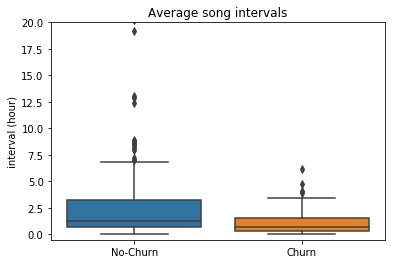

In [307]:
# plot average song intervals
sns.boxplot(data=pd_song_interval, x='Churn', y='songInterval')
plt.title('Average song intervals')
plt.xlabel('')
plt.ylabel('interval (hour)')
plt.ylim(-0.5, 20)
plt.show()

>Churn users have shorter song intervals in average.

**paid song ratios**

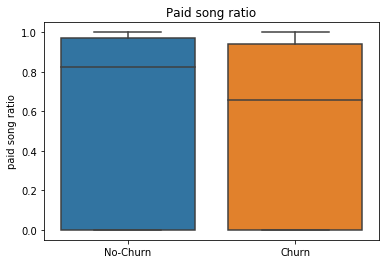

In [308]:
# plot level ratio
sns.boxplot(data=pd_level_ratio, x='Churn', y='paidRatio')
plt.title('Paid song ratio')
plt.xlabel('')
plt.ylabel('paid song ratio')
plt.show()

> Churn users have lower paid song play ratio in average.

In [309]:
# melt event count table
pd_event_count = pd_event_count.melt(id_vars=['Churn', 'userId'],
                                     value_vars=pd_event_count.columns[2:],
                                     var_name='event',
                                     value_name='countPerSong')

pd_event_count.head()

,Churn,userId,event,countPerSong
0,No-Churn,100010,About,0.003636
1,No-Churn,200002,About,0.002584
2,Churn,125,About,0.000000
3,No-Churn,124,About,0.000245
4,Churn,51,About,0.000474


**event counts per song**

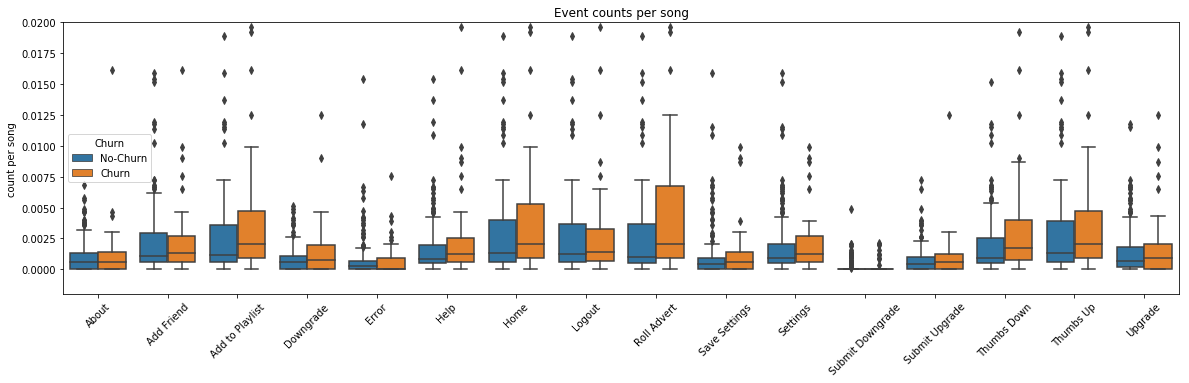

In [310]:
# plot event counts per song
plt.figure(figsize=(20, 5))
sns.boxplot(data=pd_event_count, x='event', y='countPerSong', hue='Churn')
plt.title('Event counts per song')
plt.xlabel('')
plt.ylabel('count per song')
plt.xticks(rotation=45)
plt.ylim(-0.002, 0.02)
plt.show()

>Churn users have higher counts per song in average for most of event types.

We visualized average song intervals, paid song ratio, and event counts per song, comparing churn and no-churn users.<br>
We will provide these features to machine learning models.

---
# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

---
**Dataset Contents**<br>
We will prepare following data by feature engineering.
* User ID: index
* Label: churned or not
* Features: 
    * song play event interval averaged for each user
    * paid song ratio among all song play event
    * event counts for other types of events, divided by total song count for each user
        * 'Cancel' and 'Cancellation Confirmation' events will be dropped from features.

---
**Pipeline**<br>
We will prepare feature engineering script in transformer form.<br>
Feature engineering often requires native transformers and estimators, such as 'OneHotEncoderEstimator' or 'StringIndexer', and we need to use them with 'fit' and 'transform' two step methods. It would be convenient if we could combine other feature engineering steps with the transformers and estimators, and make the whole steps into a pipeline. <br>

Spark has 'SQLTransformer()' function and it can make a SQL command into a transformer.<br>
For example, a SQL command can be written like following.
>sqlTrans1 = SQLTransformer(statement="SELECT * FROM _ _ _THIS_ _ _ WHERE userId IS NOT NULL")<br>
>sqlTransModel = sqlTrans1.fit(data)<br>
>data = sqlTransModel.transform(data)<br>

After checking the transformer is working fine, we can extract the 1st line ('sqlTrans1=...') and put it into preprocessing pipeline together with other transformers and estimators.

>preprocess_pipeline = Pipeline(stages=[sqlTrans1, sqlTrans2, sqlTrans3, oneHotEnc4, ..., stringIndexer7, ...,vectorAssembler15, sqlTrans16])

Then, we can use 'fit' and 'transform' method with the whole pipeline in one go.

>preprocess_model = preprocess_pipeline.fit(data)<br>
>data = preprocess_model.transform(data)

In this project, we actually do not have to use any OneHotEncoderEstimator, StringIndexer, nor other native transformers / estimators. But we will still keep the transformer form for future extendability.

---
**Structure of scripts**<br>
>* create_preprocess_pipeline() : Combine following three subroutines and create a pipeline of total data preprocessing.<br>
>>* add_data_cleaner() : Subroutine to add data cleaner stages in the pipeline. Shown earlier in Data Cleaning section.<br>
>>* add_label_maker(): Subroutine to add label maker stages in the pipeline. Shown earlier in Label Definition section.<br>
>>* add_features_maker() : Subroutine to add features maker stages in the pipeline. This refers to data exploratory analysis section.

In [6]:
# Feature Creater (subroutine)
def add_features_maker(stages):
    '''
    INPUT:
    stages - (list) list of transformer to be used as 'stages' argument of pyspark Pipeline() constructor
                It must be an output of 'create_label_maker()' function.

    OUTPUT:
    stages - (list) list of transformer to be used as 'stages' argument of pyspark Pipeline() constructor
    feature_labels - (list) list of feature column names for utility

    DESCRIPTION:
    This is a subroutine of create_preprocess_pipeline() function.
    Stages added by this function will make feature columns in target pyspark dataframe.
    '''
    # 'event_name'
    # replace whitespace of page column with underbar and put into a new column
    sqlTrans = SQLTransformer(statement=" \
        SELECT userId, Churn AS label, ts, registration, level, event_name \
        FROM ( \
            SELECT *, REPLACE(page, ' ', '_') AS event_name \
            FROM __THIS__)")

    stages.append(sqlTrans)

    # 'event_name' elements
    event_names = [
        'About',
        'Add_Friend',
        'Add_to_Playlist',
        # 'Cancel',
        # 'Cancellation_Confirmation',
        'Downgrade',
        'Error',
        'Help',
        'Home',
        'Logout',
        'NextSong',
        'Roll_Advert',
        'Save_Settings',
        'Settings',
        'Submit_Downgrade',
        'Submit_Upgrade',
        'Thumbs_Down',
        'Thumbs_Up',
        'Upgrade']

    # 'eventInterval'
    # add a column to store event intervals (in seconds)
    sqlTrans = SQLTransformer(statement=" \
        SELECT *, \
            ((FIRST_VALUE(ts) OVER ( \
                PARTITION BY userId, event_name \
                ORDER BY ts DESC \
                ROWS BETWEEN 1 PRECEDING AND CURRENT ROW \
            ) / 1000) - (LAST_VALUE(ts) OVER ( \
                PARTITION BY userId, event_name \
                ORDER BY ts DESC \
                ROWS BETWEEN 1 PRECEDING AND CURRENT ROW \
            ) / 1000)) AS eventInterval \
        FROM __THIS__")

    stages.append(sqlTrans)

    # 'lastTS'
    # add a column to store the last TS for each user
    sqlTrans = SQLTransformer(statement=" \
        SELECT *, \
            (FIRST_VALUE(ts) OVER ( \
                PARTITION BY userId, event_name \
                ORDER BY ts DESC \
                ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW \
            )) AS lastTS \
        FROM __THIS__")

    stages.append(sqlTrans)

    # 'trueInterval'
    # set the last TS row's interval value to Null
    sqlTrans = SQLTransformer(statement=" \
        SELECT *, \
            CASE WHEN ts == lastTS THEN NULL ELSE eventInterval END AS trueInterval \
        FROM __THIS__")

    stages.append(sqlTrans)

    # 'trueInterval'(update), 'pageCount', 'paidCount', 'songCount'
    # group by userId and page
    # we get average of interval for NextSong, and count for other events
    # we also count paid songs, and total songs
    sqlTrans = SQLTransformer(statement=" \
        SELECT label, userId, event_name, \
            AVG(trueInterval) AS trueInterval, \
            COUNT(event_name) AS pageCount, \
            COUNT(CASE WHEN event_name = 'NextSong' AND level = 'paid' THEN event_name END) AS paidCount, \
            COUNT(CASE WHEN event_name = 'NextSong' THEN event_name END) AS songCount \
        FROM __THIS__ \
        GROUP BY label, userId, event_name")

    stages.append(sqlTrans)

    # 'songInterval'
    # add a column to store interval when page is NextSong
    sqlTrans = SQLTransformer(statement=" \
        SELECT *, \
            CASE WHEN event_name == 'NextSong' THEN trueInterval END AS songInterval \
        FROM __THIS__")

    stages.append(sqlTrans)

    # 'songInterval'(update), 'paidRatio', element of event_names list as new columns
    # group by userId, average song intervals, and count other events and vidide the sum by songCount

    # loop event names to create sql lines and concatenate them
    sql_line = ''.join(['(COUNT(CASE WHEN event_name == "{}" THEN pageCount END) / SUM(songCount)) AS {},'
                        .format(name, name) for name in event_names])[:-1]

    sqlTrans = SQLTransformer(statement=" \
        SELECT label, userId, \
            MAX(songInterval) AS songInterval, \
            (MAX(paidCount) / MAX(songCount)) AS paidRatio, \
            {} \
        FROM __THIS__ \
        GROUP BY label, userId".format(sql_line))

    stages.append(sqlTrans)

    # 'featureVec'
    # assemble feature columns into a vector column
    event_names.remove('NextSong')
    feature_columns = ['songInterval', 'paidRatio'] + event_names

    assembler = VectorAssembler(
        inputCols=feature_columns, outputCol='featureVec')

    stages.append(assembler)

    # store feature labels for utility
    feature_labels = assembler.getInputCols()

    return stages, feature_labels

In [7]:
# Creating Preprocessing Pipeline (Data Cleaning + Feature Engineering)
def create_preprocess_pipeline():
    '''
    OUTPUT:
    preprocess_pipeline - (pyspark Pipeline object)
    feature_labels - (list) string labels for corresponding feature vector elements

    DESCRIPTION:
    This function creates a pipeline for data cleaning and preprocessing.
    It must be first 'fit' with data to create a pipeline model.
    Then the model can 'transform' the data.

    Example:
    > preprocess_pipeline, feature_labels = create_preprocess_pipeline()
    > preprocess_model = preprocess_pipeline.fit(data)
    > data = preprocess_model.transform(data) 
    '''
    # clean data
    stages = add_data_cleaner()

    # make label
    stages = add_label_maker(stages)

    # make features
    stages, feature_labels = add_features_maker(stages)

    # select only necessary columns, 'userId', 'label', 'features'
    sqlTrans = SQLTransformer(statement=" \
        SELECT userId, label, featureVec AS features \
        FROM __THIS__")
    stages.append(sqlTrans)

    # create preprocessing pipeline
    preprocess_pipeline = Pipeline(stages=stages)

    return preprocess_pipeline, feature_labels

>The scripts can be used as follows.<br>
>>preprocess_pipeline, feature_labels = create_preprocess_pipeline()<br>
>>preprocess_model = preprocess_pipeline.fit(data)<br>
>>processed_data = preprocess_model.transform(data)

In [8]:
# create preprocessing pipeline
preprocess_pipeline, feature_labels = create_preprocess_pipeline()

# fit and transform
preprocess_model = preprocess_pipeline.fit(data)
processed_data = preprocess_model.transform(data)

In [314]:
# save trained pipeline model to a folder
preprocess_model.write().overwrite().save('preproModel')

In [315]:
# check contents
processed_data.head(5)

[Row(userId='100010', label=0, features=DenseVector([13943.1277, 0.0, 0.0036, 0.0036, 0.0036, 0.0, 0.0, 0.0036, 0.0036, 0.0036, 0.0036, 0.0, 0.0, 0.0, 0.0, 0.0036, 0.0036, 0.0036])),
 Row(userId='200002', label=0, features=DenseVector([10183.7383, 0.7752, 0.0026, 0.0026, 0.0026, 0.0026, 0.0, 0.0026, 0.0026, 0.0026, 0.0026, 0.0, 0.0026, 0.0, 0.0026, 0.0026, 0.0026, 0.0026])),
 Row(userId='125', label=1, features=SparseVector(18, {0: 251.7143, 10: 0.125})),
 Row(userId='124', label=0, features=DenseVector([1253.9689, 1.0, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0, 0.0, 0.0002, 0.0002, 0.0])),
 Row(userId='51', label=1, features=DenseVector([646.0081, 1.0, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0, 0.0005, 0.0005, 0.0, 0.0, 0.0005, 0.0005, 0.0]))]

In [316]:
# call create_preprocess_pipeline() only for getting feature_labels
_, feature_labels = create_preprocess_pipeline()
feature_labels

['songInterval',
 'paidRatio',
 'About',
 'Add_Friend',
 'Add_to_Playlist',
 'Downgrade',
 'Error',
 'Help',
 'Home',
 'Logout',
 'Roll_Advert',
 'Save_Settings',
 'Settings',
 'Submit_Downgrade',
 'Submit_Upgrade',
 'Thumbs_Down',
 'Thumbs_Up',
 'Upgrade']

---
# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Data Standardization
We will apply standard scaling to feature vectors before sending them to classification model. <br>

In [9]:
# Standard scaling for feature vector
stdScaler = StandardScaler(withMean=True, withStd=True,
                           inputCol='features', outputCol='scaledFeatures')

---
### Metrics
As the churned users are fairly low in the data (~23%), we will use F1 score for model evaluation.<br>
Metrics calculation script is prepared as follows.<br>

Also prepared another script for precision-recall curve plot. It calculates F1, AUC (area under curve) and AP (average precision) as well.<br>
ref. [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)

In [10]:
# prepare function for metric calculation
def calculate_metrics(model_name, df_test_for_model, output=True):
    '''
    INPUT:
    model_name - (string) classification model name
    df_test_for_model - (pyspark dataframe) transformed test dataframe including prediction and label
    output - (bool) whether to print metrics to stdout

    OUTPUT:
    metrics - (dictionary) dictionary storing TP, TN, FP, FN, Precision, Recall, and F1

    DESCRIPTION:
    Print out and return TP, TN, FP, FN, Precision, Recall and F1
    '''
    # Count True Positive, True Negative, False Positive, False Negative in test data result
    sqlTrans = SQLTransformer(statement=" \
        SELECT \
            SUM(CASE WHEN label = 1 AND prediction = 1 THEN 1 ELSE 0 END) AS TP, \
            SUM(CASE WHEN label = 0 AND prediction = 0 THEN 1 ELSE 0 END) AS TN, \
            SUM(CASE WHEN label = 0 AND prediction = 1 THEN 1 ELSE 0 END) AS FP, \
            SUM(CASE WHEN label = 1 AND prediction = 0 THEN 1 ELSE 0 END) AS FN \
            FROM __THIS__")

    counts = sqlTrans.transform(df_test_for_model).collect()

    # calculate precision, recall and f1 score by definition
    TP, TN, FP, FN = counts[0].TP, counts[0].TN, counts[0].FP, counts[0].FN
    if (TP + FP) > 0:
        Precision = TP / (TP + FP)
    else:
        Precision = 0
        print('[INFO: TP + FP = 0, and Precision is set 0.]')

    if (TP + FN) > 0:
        Recall = TP / (TP + FN)
    else:
        Recall = 0
        print('[INFO: TP + FN = 0, and Recall is set 0.]')

    if (Recall + Precision) > 0:
        F1_score = 2 * Recall * Precision / (Recall + Precision)
    else:
        F1_score = 0
        print('[INFO: Recall + Precision = 0, and F1 is set 0.]')

    if output:
        print(model_name)
        print('precision:{:.4f}, recall:{:.4f}, f1:{:.4f}'.format(
            Precision, Recall, F1_score))
        print('(TP:{}, TN:{}, FP:{}, FN:{})'.format(TP, TN, FP, FN))

    metrics = {'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
               'Precision': Precision, 'Recall': Recall, 'F1': F1_score}
    return metrics

In [16]:
# Plot precision-recall curve and output F1, AUC, and AP
def plot_precision_recall_curve(df, title_addition=None, ax=None):
    '''
    INPUT:
    df - (pyspark dataframe) dataset transformed by model, including 'label', 'probability' and 'prediction' columns
    title_addition - (str) additional text string to chart title
    ax - (object) Axes object or array of Axes objects.

    DESCRIPTION:
    Plot precision-recall curve from transformed dataset.
    Also output F1 score, AUC (area under curve), and AP (average precision)
    In case ax is privided, plt.show() will not be called inside this function. (plt:matplotlib.pyplot)
    '''
    # change to pandas dataframe
    label_proba = df.select('label', 'probability', 'prediction').toPandas()

    # extract probability for 1
    label_proba['proba'] = label_proba['probability'].apply(lambda x: x[1])

    testy = label_proba['label']
    probs = label_proba['proba']
    yhat = label_proba['prediction']

    # calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(testy, probs)

    # calculate F1 score
    f1 = f1_score(testy, yhat)

    # calculate precision-recall AUC
    auc = Fauc(recall, precision)  # Fauc is an alias of sklearn.metrics auc

    # calculate average precision score
    ap = average_precision_score(testy, probs)

    print('F1={:.4f}, AUC={:.4f}, AP={:.4f} {}'.format(
        f1, auc, ap, title_addition))

    if ax is None:
        # plot no skill
        plt.plot([0, 1], [0.5, 0.5], linestyle='--')

        # plot the roc curve for the model
        plt.plot(recall, precision, marker='.')
        if title_addition is not None:
            plt.title(title_addition)
        plt.xlabel('recall')
        plt.ylabel('precision')
        plt.ylim(-0.01, 1.05)

        # show the plot
        plt.show()
    else:
        # plot no skill
        ax.plot([0, 1], [0.5, 0.5], linestyle='--')

        # plot the roc curve for the model
        ax.plot(recall, precision, marker='.')
        if title_addition is not None:
            ax.set_title(title_addition)
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.set_ylim(-0.01, 1.05)

---
### Preprocessing
For convenience, data preprocessing step is presented again.

In [12]:
# create preprocessing pipeline
preprocess_pipeline, feature_labels = create_preprocess_pipeline()

# fit and transform
preprocess_model = preprocess_pipeline.fit(data)
processed_data = preprocess_model.transform(data)

---
### Trainig and Test data split
Preprocessed dataset will be randomly split into training and testing datasets in certain ratio.<br>

In [13]:
# train, test split
df_train, df_test = processed_data.randomSplit([0.7, 0.3], seed=24)

---
### Model selection
We will use 'Logistic Regression' and 'Gradient Boosted-Tree Classifier' for modeling.<br>
1. Logistic Regression is relatively faster to train. So it is convenient for preliminary trial.<br>
* Gradient Boosted-Tree Classifier takes much longer time for training. But it often scores better.<br>

#### 1. Logistic Regression

First, we check F1 score with default parameters.

In [14]:
# Logistic Regression (training with default parameters)
lr = LogisticRegression(featuresCol='scaledFeatures',
                        labelCol='label', standardization=False)

# pipeline with standard scaler
lr_pipeline = Pipeline(stages=[stdScaler, lr])

# training model
lrModel = lr_pipeline.fit(df_train)

In [323]:
# calculate metrics with training data
df_train_lr = lrModel.transform(df_train)
_ = calculate_metrics(
    'Logistic Regression (train, default params)', df_train_lr)

Logistic Regression (train, default params)
precision:0.8333, recall:0.4054, f1:0.5455
(TP:15, TN:117, FP:3, FN:22)


In [324]:
# calculate metrics with test data
df_test_lr = lrModel.transform(df_test)
_ = calculate_metrics('Logistic Regression (test, default params)', df_test_lr)

Logistic Regression (test, default params)
precision:0.4000, recall:0.2667, f1:0.3200
(TP:4, TN:47, FP:6, FN:11)


>train set score: F1=0.5455, test set score: F1=0.3200<br>
Both scores are not so good. It indicates under-fitting.<br>
We try improving it by parameter tuning with grid search.

---
**Parameter Tuning - Logistic Regression**<br>
We use grid search with three fold cross validation method.<br>
As the churned users are fairly low in the data, we use 'the area under the precision-recall curve' for the parameter optimization.<br>
>Ref. [BinaryClassificationEvaluator - PySpark docs](https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html?highlight=binaryclassificationevaluator#pyspark.ml.evaluation.BinaryClassificationEvaluator)<br>
Ref. [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)


We vary 'maxIter' parameter by grid search.<br>
'standardization' option is set off because we have prepared standard scaler separately.

In [15]:
# Logistic Regression (training by grid search)
lr = LogisticRegression(elasticNetParam=0.0, featuresCol='scaledFeatures',
                        labelCol='label', standardization=False)

# pipeline with standard scaler
lr_pipeline = Pipeline(stages=[stdScaler, lr])

# grid search parameters
lr_grid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10, 50, 100, 200]) \
    .build()

# evaluator
lr_evaluator = BinaryClassificationEvaluator(
    metricName='areaUnderPR')  # precision-recall-curves

# grid search with 3 folds cross validation
lr_cv = CrossValidator(estimator=lr_pipeline,
                       estimatorParamMaps=lr_grid,
                       evaluator=lr_evaluator,
                       numFolds=3)

# training model
lrModel = lr_cv.fit(df_train)

In [16]:
# calculate metrics with training data
df_train_lr = lrModel.transform(df_train)
_ = calculate_metrics('Logistic Regression (train, grid-search)', df_train_lr)

Logistic Regression (train, grid-search)
precision:0.8333, recall:0.4054, f1:0.5455
(TP:15, TN:117, FP:3, FN:22)


In [17]:
# calculate metrics with test data
df_test_lr = lrModel.transform(df_test)
_ = calculate_metrics('Logistic Regression (test, grid-search)', df_test_lr)

Logistic Regression (test, grid-search)
precision:0.4000, recall:0.2667, f1:0.3200
(TP:4, TN:47, FP:6, FN:11)


In [18]:
# save the best pipeline to a folder
lrModel.bestModel.write().overwrite().save('lrModelCV')

In [19]:
# extract the best model parameters
bestLrClassifier = lrModel.bestModel.stages[-1]
bestLrClassifier.extractParamMap()

{Param(parent='LogisticRegression_6d59a6b9961c', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LogisticRegression_6d59a6b9961c', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0,
 Param(parent='LogisticRegression_6d59a6b9961c', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto',
 Param(parent='LogisticRegression_6d59a6b9961c', name='featuresCol', doc='features column name'): 'scaledFeatures',
 Param(parent='LogisticRegression_6d59a6b9961c', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LogisticRegression_6d59a6b9961c', name='labelCol', doc='label column name'): 'label',
 Param(parent='LogisticRegression_6d59a6b9961c', name='maxIter', doc='maximum number of iterations (>= 

>The best model train set score is F1=0.5455 and test set score is F1=0.3200 with 'maxIter'=200.<br>
Grid search did not improve scores, but the best model score should be more stable after going through cross validation process.

We check precision-recall curve.

F1=0.5455, AUC=0.7382, AP=0.7414 train set
F1=0.3200, AUC=0.3189, AP=0.3555 test set


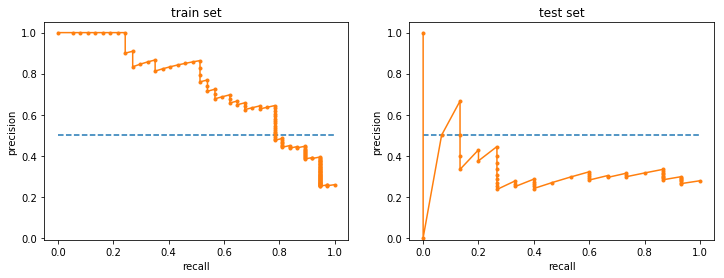

In [20]:
# plot precision-recall curve
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_precision_recall_curve(df_train_lr, title_addition='train set', ax=ax[0])
plot_precision_recall_curve(df_test_lr, title_addition='test set', ax=ax[1])
plt.show()

>Blue dot line is the baseline of PR curve.<br>
Test set AUC (area under PR curve) is 0.3189 and it is below baseline (0.5).

**Score Summary - Logistic Regression**

|CV(maxIter=200)|precison|recall|f1|AUC|AP|
|---|---|---|---|---|---|
|mini data train set|0.8333|0.4054|0.5455|0.7382|0.7414|
|mini data test set|0.4000|0.2667|0.3200|0.3189|0.3555|

>Test set score F1=0.3200 is not very satisfactory. Train set score F1=0.5455 is not high, eigher.<br>
This indicates under-fitting.<br>

>For reference, result of modeling with medium size data is shown as follows.

|CV(maxIter=10)|precison|recall|f1|AUC|AP|
|---|---|---|---|---|---|
|medium data train set|0.8333|0.4348|0.5714|0.6514|0.6570|
|medium data test set|0.5000|0.1333|0.2105|0.5195|0.5366|

>Grid paremeters were same for both, but different 'maxIter' were selected for the best models.
Medium size data result is not so good, either.

>As train set score is not very high, test set score cannot be good in principle.<br>
Maybe this feature set exceeded learning capacity of Logistic Regression model.<br>
We could try adding or reducing features to see if it improves.<br>
But rather we will try another classification model, first.

---
#### 2. Gradient Boosted-Tree Classifier

First, we try with default parameters.

In [21]:
# Gradient Boosted-Tree Classifier (training with default parameters)
gbt = GBTClassifier(featuresCol='scaledFeatures', labelCol='label')

# pipeline with standard scaler
gbt_pipeline = Pipeline(stages=[stdScaler, gbt])

gbtModel = gbt_pipeline.fit(df_train)

In [326]:
# calculate metrics with training data
df_train_gbt = gbtModel.transform(df_train)
_ = calculate_metrics(
    'Gradient Boosted-Tree Classifier (train, default params)', df_train_gbt)

Gradient Boosted-Tree Classifier (train, default params)
precision:1.0000, recall:1.0000, f1:1.0000
(TP:37, TN:120, FP:0, FN:0)


In [327]:
# calculate metrics with test data
df_test_gbt = gbtModel.transform(df_test)
_ = calculate_metrics(
    'Gradient Boosted-Tree Classifier (test, default params)', df_test_gbt)

Gradient Boosted-Tree Classifier (test, default params)
precision:0.5263, recall:0.6667, f1:0.5882
(TP:10, TN:44, FP:9, FN:5)


>Test set score is F1=0.5882 and it is not so bad.<br>
While, train set score is F1=1.0, and this gap indicates over-fitting.<br>
We try improving it by parameter tuning with grid search.

**Parameter Tuning - Gradient Boosted-Tree Classifier**<br>
We vary 'maxIter' parameter by grid search.

In [22]:
# grid search parameters
gbt_grid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20, 50]) \
    .build()

# evaluator
gbt_evaluator = BinaryClassificationEvaluator(
    metricName='areaUnderPR')  # precision-recall-curve

# grid search with 3 folds cross validation
gbt_cv = CrossValidator(estimator=gbt_pipeline,
                        estimatorParamMaps=gbt_grid,
                        evaluator=gbt_evaluator,
                        numFolds=3)

gbtModel = gbt_cv.fit(df_train)

In [23]:
# calculate metrics with training data
df_train_gbt = gbtModel.transform(df_train)
_ = calculate_metrics(
    'Gradient Boosted-Tree Classifier (train, grid-search)', df_train_gbt)

Gradient Boosted-Tree Classifier (train, grid-search)
precision:1.0000, recall:1.0000, f1:1.0000
(TP:37, TN:120, FP:0, FN:0)


In [24]:
# calculate metrics with test data
df_test_gbt = gbtModel.transform(df_test)
_ = calculate_metrics(
    'Gradient Boosted-Tree Classifier (test, grid-search)', df_test_gbt)

Gradient Boosted-Tree Classifier (test, grid-search)
precision:0.5000, recall:0.6667, f1:0.5714
(TP:10, TN:43, FP:10, FN:5)


In [25]:
# save the best pipeline to a folder
gbtModel.bestModel.write().overwrite().save('gbtModelCV')

In [26]:
# extract the best model parameters
bestGbtClassifier = gbtModel.bestModel.stages[-1]
bestGbtClassifier.extractParamMap()

{Param(parent='GBTClassifier_e262b5a8270e', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='GBTClassifier_e262b5a8270e', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='GBTClassifier_e262b5a8270e', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'all',
 Param(parent='GBTClassifier_e262b5a8270e', name='featuresCol', doc='features column name'): 'scaledFeatures',
 Param(parent='GBTClassifier_e262b5a8270e', name='labelCol', doc='label column name'

>The best model train set score is F1=1.0 and test score is F1=0.5714 with 'maxIter'=50.<br>
Grid search did not improve scores, but the best model score should be more stable after going through cross validation process.

We plot precision-recall curve.

F1=1.0000, AUC=1.0000, AP=1.0000 train set
F1=0.5714, AUC=0.5174, AP=0.5386 test set


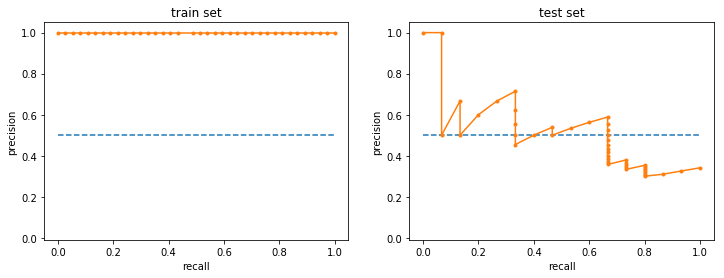

In [27]:
# plot precision-recall curve
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_precision_recall_curve(df_train_gbt, title_addition='train set', ax=ax[0])
plot_precision_recall_curve(df_test_gbt, title_addition='test set', ax=ax[1])
plt.show()

>Test set AUC is 0.5174 and it is barely above baseline (0.5).

**Score Summary - Gradient Boosted-Tree Classifier**

|CV(maxIter=50)|precison|recall|f1|AUC|AP|
|---|---|---|---|---|---|
|mini data train set|1.0000|1.0000|1.0000|1.0000|1.0000|
|mini data test set|0.5000|0.6667|0.5714|0.5174|0.5386|

>Train set score F1=1.0 definitely indicates over-fitting. But test set score F1=0.5714 is not so bad.<br>

>For reference, result of modeling with medium size data is shown as follows.

|CV(maxIter=50)|precison|recall|f1|AUC|AP|
|---|---|---|---|---|---|
|medium data train set|1.0000|1.0000|1.0000|1.0000|1.0000|
|medium data test set|0.5938|0.6333|0.6129|0.6253|0.6333|

>Train set score is still F1=1.0, but test set scores are higher than mini set case.<br>
It might be because over-fitting is relieved by larger dataset.

**Feature Importances**<br>
Feature importances can be extracted from Gradient Boosted-Tree model.

In [28]:
# load trained Gradient Boosted-Tree Classifier model from folder
saved_gbtModel = PipelineModel.load('gbtModel')

# get the best model and its feature importances
bestGbtModel = saved_gbtModel.stages[-1]
feature_importances = bestGbtModel.featureImportances.toArray()
feature_importances

array([ 0.2716972 ,  0.063029  ,  0.01721443,  0.05029233,  0.03618423,
        0.05167619,  0.02291726,  0.01275392,  0.02568938,  0.02134946,
        0.08800991,  0.09177802,  0.05201915,  0.02510823,  0.01989973,
        0.04197814,  0.01910125,  0.08930217])

In [29]:
# change feature_labels to numpy array
feature_labels_arr = np.array(feature_labels)
feature_labels_arr

array(['songInterval', 'paidRatio', 'About', 'Add_Friend',
       'Add_to_Playlist', 'Downgrade', 'Error', 'Help', 'Home', 'Logout',
       'Roll_Advert', 'Save_Settings', 'Settings', 'Submit_Downgrade',
       'Submit_Upgrade', 'Thumbs_Down', 'Thumbs_Up', 'Upgrade'], 
      dtype='<U16')

In [30]:
# sort feature importances and get indices
sorted_indices = np.argsort(feature_importances)[::-1]

# get sorted importance list and label list
sorted_labels = feature_labels_arr[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# scale to max value
sorted_importances = sorted_importances / np.max(sorted_importances)

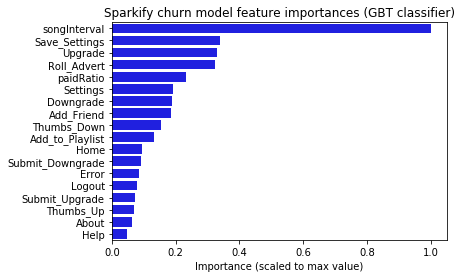

In [31]:
# plot feature importances (Gradient Boosted-Tree Classifier)
sns.barplot(x=sorted_importances, y=sorted_labels, orient='h', color='blue')
plt.title('Sparkify churn model feature importances (GBT classifier)')
plt.xlabel('Importance (scaled to max value)')
plt.show()

>'songInterval' (song inteval) is the most important feature for the Gradient Boosted-Tree model with mini dataset.<br>

>Medium set result also shows that song interval is the most important. But the ranking of other features are different. (Please refer to medium set note.)

# Summary and Conclusion
Sparkify event log data was analyzed and churn prediction models were built.<br>
In order to handle big data by cluster computing, Pyspark was mainly used for data preprocessing and modeling.<br>
Mini size dataset was worked on local workspace (this note), and medium size dataset was worked on IBM Watson Studio (another note).

**Exploratory Data Analysis and Feature Engineering**<br>
User event timeline patterns were visualized, comparing churn and no-churn groups.<br>
Differences were observed in event blank patterns. Thus, song play intervals were taken into modeling features.<br>
Paid song ratio, and other events' count per song, were also taken into features.<br>

**Modeling and Reflection**<br>
Logistic Regression and Gradient Boosted-Tree Classifier were tried for churn prediction modeling.<br>

Logistic Regression did not show good performance.<br>

|LR (maxIter=200)|precison|recall|f1|AUC|AP|
|---|---|---|---|---|---|
|mini data train set|0.8333|0.4054|0.5455|0.7382|0.7414|
|mini data test set|0.4000|0.2667|0.3200|0.3189|0.3555|

|LR (maxIter=10)|precison|recall|f1|AUC|AP|
|---|---|---|---|---|---|
|medium data train set|0.8333|0.4348|0.5714|0.6514|0.6570|
|medium data test set|0.5000|0.1333|0.2105|0.5195|0.5366|

Test set scores were F1=0.32 (mini set) and F1=0.21 (medium set).<br>
Train set scores were F1=0.55 (mini set) and F1=0.57 (medium set).<br>
As both of train set and test set scores were not good, it is presumed that the features were exceeding learning capacity of the model.<br>

On the other hand, Gradient Boosted-Tree Classifier showed pretty good performance. <br>

|GBT (maxIter=50)|precison|recall|f1|AUC|AP|
|---|---|---|---|---|---|
|mini data train set|1.0000|1.0000|1.0000|1.0000|1.0000|
|mini data test set|0.5000|0.6667|0.5714|0.5174|0.5386|

|GBT (maxIter=50)|precison|recall|f1|AUC|AP|
|---|---|---|---|---|---|
|medium data train set|1.0000|1.0000|1.0000|1.0000|1.0000|
|medium data test set|0.5938|0.6333|0.6129|0.6253|0.6333|

Test set scores were F1=0.57 (mini set) and F1=0.61 (medium set).<br>
Train set scores were F1=1.0 with both mini set and medium set data.<br>
As train set scores were 1.0, indicating over-fitting, it is presumed that the model scored higher with larger dataset due to less over-fitting effect.

If we remember that actual churn rate of this data is about 23%, random guess scores can be calculated as following cell. And random guess F1 scores can be up to 0.37. Logisitc Regresssion score is same level as random guess, while Gradient Boosted-Tree Classifier is clearly higher than random guess.

Feature importances were extracted from the Gradient Boosted-Tree Classifier, and song intervals feature was found to be the most important for the model. This result is supporting the observed difference of timeline event patterns in visualization. (By the way, it is not intuitively understandable why churn users have less song intervals in average. We would need business segment inputs and further analysis to find it.)


**Improvement Ideas**
- For both models, adding or reducing features could be tried. For example, gender, user-agent, number of distinct songs or artist, could be added.
- For Gradient Boosted-Tree Classifier, full size dataset might further improve performance if over-fitting effect is relieved by the data size.  (It is omitted due to budget constrain this time.)
- This time, song play intervals were simply averaged for each user. Instead, it might be interesting if we could put the timeline event patterns as compressional wave, and extract frequency components for features.

---
**Random Guess Scores**<br>
When actual churn rate is 23% and we randomly guess number of A users as churn out of total N users, our chance of correct answers are as follows.<br>
- Number of True Positive(TP) = A x 0.23
- Number of True Negative(TN) = (N - A) x 0.77

And our chance of wrong answers are as follows.
- Number of False Positive(FP) = (N - A) x 0.23
- Number of False Negative(FN) = A x 0.77

Then, Precision, Recall and F1 score can be calculated as follows.
- Precison = TP / (TP + FP) = A x 0.23 / (A x 0.23 + (N - A) x 0.23) = A/N
- Recall = TP / (TP + FN) = A x 0.23 / (A x 0.23 + A x 0.77) = 0.23<br>
- F1 = 2 x Precision x Recall / (Precision + Recall) = 2 x (A/N) x 0.23 / (A/N + 0.23)

Precision and F1 depend on number of churn predicition in total number, A/N.<br>
We plot chart as follows.

F1:[0.0, 0.1393939393939394, 0.21395348837209302, 0.26037735849056609, 0.29206349206349208, 0.31506849315068497, 0.33253012048192776, 0.34623655913978502, 0.35728155339805828, 0.36637168141592918, 0.37398373983739841]


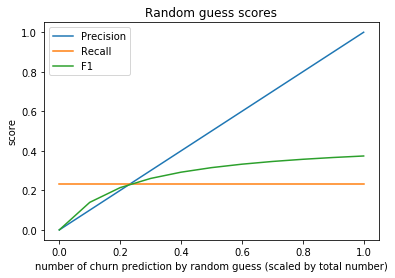

In [15]:
AinN = np.arange(0, 1+0.1, 0.1)
precision = AinN
recall = [0.23] * len(AinN)
f1 = [2 * an * 0.23 / (an + 0.23) for an in AinN]
print('F1:{}'.format(f1))

# plot
plt.plot(AinN, precision, label='Precision')
plt.plot(AinN, recall, label='Recall')
plt.plot(AinN, f1, label='F1')
plt.title('Random guess scores')
plt.xlabel('number of churn prediction by random guess (scaled by total number)')
plt.ylabel('score')
plt.legend()
plt.show()

---
# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

---
**Web Application**<br>
A demonstrative web application will be separately created, and we prepare following for that.<br>
- Preprocessing pipeline (__preproModel/__): Pipeline that cleans and transforms data to features and label. We have saved it to a folder earlier.
- Trained classification model (__gbtModelCV/__): Gradient Boosted-Tree Classifier. We have saved trained model to a folder earlier.
- Test set user ID list (__test_set_user_ids.csv__): This will be used to make demo data in the web application. It is prepared as follows.

First, we need to recreate the same test set as we used earlier in order to get userId from it.<br>

In [26]:
# load preprocess pipeline from folder
preproModel = PipelineModel.load('preproModel')

In [27]:
# process raw data with the loaded pipeline model
processed_data = preproModel.transform(data)

In [28]:
# train, test split (use only test set for application)
_, df_test = processed_data.randomSplit([0.7, 0.3], seed=24)

In [ ]:
# changed to Pandas dataframe and save to CSV
pd_userId = df_test.select('userId').toPandas()
pd_userId.to_csv('test_set_user_ids.csv')

Now test set user ID list is saved to a CSV file. <br>
Web application will use it for making demo data.<br>
For overview of the web application, please refer to README.MD file.